In [1]:
pip install causalml

     |████████████████████████████████| 406 kB 17.0 MB/s 
     |████████████████████████████████| 564 kB 40.1 MB/s 
     |████████████████████████████████| 1.8 MB 47.9 MB/s 
     |████████████████████████████████| 718 kB 51.0 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
  Created wheel for causalml: filename=causalml-0.12.3-cp37-cp37m-linux_x86_64.whl size=1050940 sha256=70077d4c035458874cf7ef7464df3d164c95c014de552c808dee6ae2fd617fea
  Stored in directory: /root/.cache/pip/wheels/d7/5e/47/4e965cf8e87c6c10cd7361d910acccd08a1de459f25d55fd23
Successfully built causalml
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have t

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from causalml.inference.meta import BaseXRegressor, BaseSRegressor, BaseTRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# データをダウンロード
path = 'https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'
df = pd.read_csv(path)

X = df[['area_kanto', 'area_tokai', 'area_keihanshin', 'age', 'sex', 'marry_dummy', 'child_dummy',
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7', 
        'inc', 'pmoney', 'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'TVwatch_day']]
Y = df['gamesecond'] # アプリ利用秒数
W = df['cm_dummy'] # CM接触有無

# 学習データとテストデータに分割 (Wで層化)
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.2, shuffle=True, random_state=42, stratify=W)

In [4]:
# S-Learnerインスタンスを作成 (今回はXGBoostベース)
learner_s = BaseSRegressor(learner=XGBRegressor(random_state=42))

# 学習
learner_s.fit(X=X_train, treatment=W_train, y=Y_train)

# テストデータに対して予測
cate_s = learner_s.predict(X=X_test)

[12:31:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
cate_s

array([[    0.        ],
       [    0.        ],
       [-4962.39453125],
       ...,
       [    0.        ],
       [    0.        ],
       [    0.        ]])

In [7]:
# T-Learnerインスタンスを作成 (今回はXGBoostベース)
learner_t = BaseTRegressor(learner=XGBRegressor(random_state=42))

# 学習
learner_t.fit(X=X_train, treatment=W_train, y=Y_train)

# テストデータに対して予測
cate_t = learner_t.predict(X=X_test)

[12:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [8]:
# X-Learnerインスタンスを作成 (今回はXGBoostベース)
learner_x = BaseXRegressor(learner=XGBRegressor(random_state=42))

# 学習
# 今回のように傾向スコアを指定しない場合は、ElasticNetにより自動で計算される
learner_x.fit(X=X_train, treatment=W_train, y=Y_train)

# テストデータに対して予測
cate_x = learner_x.predict(X=X_test)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

[12:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:32:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:33:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Distribution of CATE')

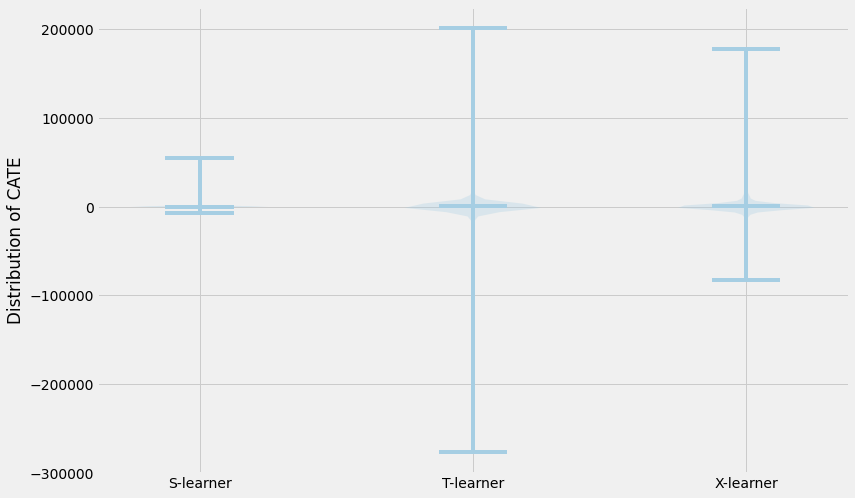

In [9]:
plt.figure(figsize=(12,8))
plt.violinplot([cate_s.flatten(), cate_t.flatten(), cate_x.flatten()], showmeans=True)
plt.xticks([1,2,3], ['S-learner', 'T-learner', 'X-learner'])
plt.ylabel('Distribution of CATE')